# 1. Introduction

## 1.1 Importing and Installing necessary Modules

Before we start with the Notebook itself, let us make sure that all necessary modules are installed and loaded. We assume that modules like *os*, *datetime* and *random* are natively installed.

In [264]:
packages_installed = !pip list # Get a list of installed packages
packages_installed = [x.split()[0] for x in packages_installed] # Get names and convert to list

needed_packages = ["pandas", "scikit-learn", "numpy", "seaborn", "matplotlib", "xgboost", "scipy", "joblib"] # Needed packages

# Iterate over needed packages and check whether they are installed or not, if False, install them via pip
for pack in needed_packages:
    check = pack in packages_installed
    if check == True:
        print("Module %s is already installed" %pack)
    else:
        print("Module %s will be installed" %pack) 
        !pip install pack

Module pandas is already installed
Module scikit-learn is already installed
Module numpy is already installed
Module seaborn is already installed
Module matplotlib is already installed
Module xgboost is already installed
Module scipy is already installed
Module joblib is already installed


Next, we import all necessary modules and dependencies.

In [265]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn import metrics
from sklearn.utils import shuffle
from joblib import dump, load

Set global plot style.

In [266]:
import matplotlib as mpl
mpl.style.use("seaborn-darkgrid")
my_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]

In [267]:
import warnings # Suppress depreciation warnings for the sklearn API of XGBoost.

## 1.2 Problem Description and Embedding of Objective as Business Problem

Online retail is here to stay and primed to grow even further. This is especially eminent in the current light of the COVID-19 pandemic where most of the brick and mortar stores are closed due to lockdowns or stay-at-home orders leading to more and more individuals to purchase items online. However, one of the most severe issues for online retailers compared to brick and mortar stores are return costs (see for example [this article](https://seekingalpha.com/article/4325590-online-vs-in-store-retail-cost-comparison)). This is even more so the case for online fashion retailers as most individuals will often buy more than one size of one article and will return the size that did not fit or they decided that they do not like the item after they have seen it firsthand. Reducing the number of returns or more specifically encouraging customers to refrain from buying products they are likely to return is vital to ensure a profitable operation. Essentially, this task boils down to predict whether a particular order will be returned by the customer or not. Thus, the task can be seen as a classification problem, where our target variable can only take values in $\{0,1\}$, where $0$ means that the item will not be returned, and $1$ means that the item will be returned. If we could infer beforehand whether an item will be returned, we could apply various measures to nudge the customer into not buying this item, e.g. a warning message or not allowing to pay per invoice. This would in turn result in lesser unnecessary shipping and reduce the firm’s return costs. \
With this setting in mind this case study uses real-world data to develop a statistical model which is used to predict returns of item orders incorporating an asymmetric cost matrix that depends on the items’ price. We begin by analyzing the given cost matrix in section 1.3 and continue by exploring the data set for which labels have been provided in section 2. Continuing in section 3, we present our approach for the data preparation and feature selection which is then followed by the model development in section 4. The penultimate section 5 presents the results of our model on a hold-out test set and finally section 6 concludes. 


## 1.3 Analysis of Cost Matrix

The cost matrix is given through
\begin{equation}
\mathcal{C} := \begin{pmatrix} 0 & \frac{5}{2}\left(3 + \frac{1}{10}\nu \right) \\ \frac{1}{2} \nu & 0 \end{pmatrix},
\end{equation}
where $\nu$ denotes the item price. We therefore assume 0 costs for a true positive (TP) ($\mathcal{C}_{2,2}$) and 0 for a true negative (TN) prediction ($\mathcal{C}_{1,1}$). $\mathcal{C}_{1,2}$ displays the cost for a false negative (FN) and $\mathcal{C}_{2,1}$ displays the cost for a false positive (FP) prediction. Setting $\mathcal{C}_{2,1} = \mathcal{C}_{1,2}$ and solving for $\nu$ yields
$$\nu_T = 30.$$
This (threshold) price has the following implications for the misclassification costs
\begin{align*}
\mathcal{C}_{2,1} &\geq \mathcal{C}_{1,2} \quad \quad , \nu \geq 30\\
\mathcal{C}_{2,1} &< \mathcal{C}_{1,2} \quad \quad , \nu < 30,
\end{align*}
meaning intuitively that the cost of a FP exceeds the cost of a FN classification whenever the item price is higher than 30 EUR, and vice-versa for an item price lower than 30 EUR. This can also be visually depicted as the following graph shows.

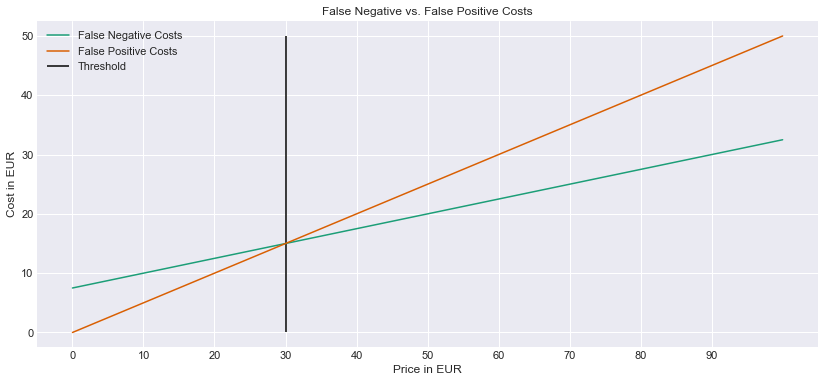

In [268]:
prices = np.arange(0,101, 1) # Define x values (prices)
fn_costs = 5/2 * (3 + 1/10 * prices) # Calculate FN costs
fp_costs = 1/2 * prices # Calculate FP costs

plt.figure(figsize= (14,6)) # Plot size
plt.plot(prices, fn_costs, label = "False Negative Costs", color = my_colors[0])
plt.plot(prices, fp_costs, label = "False Positive Costs", color = my_colors[1])
plt.vlines(30, ymin = 0, ymax = max(fp_costs), color = "black", label = "Threshold")
plt.xlabel("Price in EUR")
plt.ylabel("Cost in EUR")
plt.xticks(np.arange(0, 100, step = 10))
plt.title("False Negative vs. False Positive Costs")
plt.legend()
plt.show()

Depending on the price distribution in the (training) data set, an algorithm might thus favor having more FNs than FPs or vice-versa. This is in the essence the asymmetric property of the cost matrix.
This discussion motivates the following benchmark algorithm that our model has at least to outperform. Denote with $X \in \mathbb{R}^{n\times p}$ the design matrix, with $y \in \{0,1\}^n$ the target variable and with $\nu \in \mathbb{R}_+^n$ as before the item price. Then the benchmark algorithm given the cost matrix $\mathcal{C}$ is given through
\begin{equation}\label{eq:bench}
h_{\text{bench}}(X, y) := \left( \mathbb{1}_{\{\nu_i~ < ~30\}}\right)_{i = 1,\dots, n},
\end{equation}
where $\mathbb{1}_{\{\cdot\}}$ is the indicator function. \
Besides this (main) benchmark model we will also compare our model to an algorithm that classifies the input randomly, i.e.
\begin{equation}
h_{\text{rand}}(X, y) := (Z_i)_{i = 1, \dots, n} \quad \quad, Z_i \stackrel{\text{i.i.d.}}{\thicksim} \text{Ber}(p = \frac{1}{2}).
\end{equation} 
Finally, we will derive a third benchmark algorithm, that resembles the implementation of no such algorithm for return detection, i.e.
\begin{equation}
h_{\text{neg}}(X, y) := 0.
\end{equation}
Furthermore, as mentioned the asymmetric costs lead to metrics like $AUC$ being not enough to find an optimal classifier, since the model has to account for the difference in costs for FN and FP predictions based on the item price. In section 4 we will elaborate more on the model construction and describe how we overcome this issue. Let us continue with the important topic of data exploration to get a first glance on our data.


# 2. Explanatory Data Analysis

As with any data analytics we begin by exploring the data set. We will focus on the “known” data set (from here on called labeled data set) in this and the following section since in the real-world we would be only given a labeled data set and the unknown data set (unlabeled data set) would only consist of observations one at a time. However, as we will explain in detail in section 3, we will still apply various transformations on the labeled data set and thus also on the unlabeled data set. \
Let us begin by loading in the data sets from the forked Github Repo “bads”. We also create copy of the data for comparison later.

In [269]:
# Store links to Github files 
url_known = "https://raw.githubusercontent.com/TaTo0101/bads/master/kaggle/data/BADS_WS2021_known.csv"
url_unknown = "https://raw.githubusercontent.com/TaTo0101/bads/master/kaggle/data/BADS_WS2021_unknown.csv"

# Load un- and known data sets as pandas data frame
data = pd.read_csv(url_known, sep = ",", index_col='order_item_id') # Known data set
data_u = pd.read_csv(url_unknown, sep = ",", index_col='order_item_id') # Unknown data set

# For comparison later
og_data = data.copy()
og_data_u = data_u.copy()

During our initial analysis we found that some sizes where encoded as upper cases in the unlabeled data set and as lower cases in the labeled data set. Since those sizes are in fact identical, e.g. *XL* and *xl*, we convert all sizes to lower cases to avoid separation of otherwise identical categories.

In [270]:
data["item_size"] = data["item_size"].str.lower()
data_u["item_size"] = data_u["item_size"].str.lower()

To able to do a proper visual analysis of the labeled data set, we need to convert some variables to appropriate data types, e.g. *item_color* should be encoded as *category*. We thus do the following: Convert
- *item_size*, *item_color*, *user_title* and *user_state* to category;
- *return* to bool;
- *order_date*, *user_reg_date*, *delivery_date* and *user_dob* to datetime.

Note that we do not convert *brand_id* nor *item_id* to the type category. The reason for this is that this would cause dimensionality issues in the analysis later. Furthermore, since the number of unique categories for *item_id* and for that matter *brand_id* are fairly large we could accept the integer conversion as a rough approximation.

In [271]:
filter_date = ["order_date", "user_reg_date", "delivery_date", "user_dob"] # filter for variables to be changed to datetime
data[filter_date] = data[filter_date].apply(pd.to_datetime,format = "%Y-%m-%d") # change variables type to datetime

filter_cat = ["item_size", "item_color", "user_title", "user_state"] # filter for variables to be changed to category
data[filter_cat] = data[filter_cat].astype("category") # change variables type to category

data["return"] = data["return"].astype(bool) # Change return type to bool

# Repeat exercise for unknown data set
data_u[filter_date] = data_u[filter_date].apply(pd.to_datetime,format = "%Y-%m-%d")
data_u[filter_cat] = data_u[filter_cat].astype("category")

First, we check whether there are categories for the variables *item_size* and *item_color* that only appear in the un- or in the labeled data set. Let us begin to look at the colors and sizes that are only contained in the labeled data set.

In [272]:
union_size = data["item_size"].cat.categories.sort_values().intersection(data_u["item_size"].cat.categories.sort_values()) # Get the union of all sizes from both datasets
union_col = data["item_color"].cat.categories.sort_values().intersection(data_u["item_color"].cat.categories.sort_values()) # Get the union of all colors from both datasets

difference_known_size = data["item_size"].cat.categories.sort_values().difference(union_size) # Item sizes that don't appear in the unknown data set
difference_known_color = data["item_color"].cat.categories.sort_values().difference(union_col) # Item colors that don't appear in the unknown data set

print(difference_known_size) # Sizes not in unknown
print(difference_known_color) # Colors not in unknown

Index(['105', '2+', '3132', '3634', '3834', '4034', '49', '58', '80', '84'], dtype='object')
Index(['amethyst', 'apricot', 'avocado', 'baltic blue', 'caramel', 'curled',
       'currant purple', 'dark grey', 'mint', 'opal'],
      dtype='object')


Furthermore, let us explore how many observations there are for each color and size that is not in the unlabeled data set but in the labeled one. 

In [273]:
# Observations per sizes category
obs_diff_known_siz = data.loc[data["item_size"].isin(difference_known_size), "item_size"].value_counts()

# Observations per color category
obs_diff_known_col = data.loc[data["item_color"].isin(difference_known_color), "item_color"].value_counts()
print(obs_diff_known_col[obs_diff_known_col > 0]), print(obs_diff_known_siz[obs_diff_known_siz > 0])

mint              137
dark grey          39
baltic blue        20
curled             13
apricot            10
caramel            10
currant purple      7
amethyst            5
avocado             4
opal                2
Name: item_color, dtype: int64
58      5
80      2
2+      2
3634    1
3132    1
49      1
84      1
4034    1
3834    1
105     1
Name: item_size, dtype: int64


(None, None)

We see that the numbers are pretty low, compared to the size of our labeled data set. Now, let us repeat this exercise for the unlabeled data set.

In [274]:
difference_unknown_size = data_u["item_size"].cat.categories.sort_values().difference(union_size) # Item sizes that don't appear in the known data set
difference_unknown_color = data_u["item_color"].cat.categories.sort_values().difference(union_col) # Item colors that don't appear in the known data set

print(difference_unknown_size) # Sizes not in unknown
print(difference_unknown_color) # Colors not in unknown

# Observations per sizes category
obs_diff_unknown_siz = data_u.loc[data_u["item_size"].isin(difference_unknown_size), "item_size"].value_counts()

# Observations per color category
obs_diff_unknown_col = data_u.loc[data_u["item_color"].isin(difference_unknown_color), "item_color"].value_counts()
print(obs_diff_unknown_col[obs_diff_unknown_col > 0]), print(obs_diff_unknown_siz[obs_diff_unknown_siz > 0])

Index(['110', '122', '4232', '95'], dtype='object')
Index([], dtype='object')
Series([], Name: item_color, dtype: int64)
122     3
4232    1
110     1
95      1
Name: item_size, dtype: int64


(None, None)

As we can see, only four sizes are not contained in the labeled data set and again the numbers are minuscule compared to the size of our unlabeled data set. \
Our main interest lies in features that are informative regarding our target variable. When looking at the variables *item_color* and *item_size* we could calculate whether there are sizes or color for which the order was always returned or not returned. If the number of observations are reasonable large enough, one could derive the conclusion that those categories are a strong indicator on whether this particular item will be returned. 


In [275]:
tab_size = pd.crosstab(data.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1) # Create a cross table for return and item size
ratios_size = tab_size[(tab_size[0] == 0) | (tab_size[1] == 0)] # Retrieve only those sizes where the return rate is either 0 or 1
tab_color = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1) # Create a cross table for return and item color
ratios_col = tab_color[(tab_color[0] == 0) | (tab_color[1] == 0)] # Retrieve only those colors where the return rate is either 0 or 1

obs_size = data[data.item_size.isin(ratios_size.index)].value_counts(subset = "item_size") # Retrieve Observations for those sizes
obs_col = data[data.item_color.isin(ratios_col.index)].value_counts(subset = "item_color") # Retrieve Observations for those colors


table_1 = pd.DataFrame({"Ratio returned": ratios_size.append(ratios_col)[1], "Observations" : obs_size[obs_size >0].append(obs_col[obs_col >0])}) # Create table
table_1 

,Ratio returned,Observations
105,0.0,1
12+,1.0,1
2+,1.0,2
3132,1.0,1
3432,0.0,13
3634,0.0,1
3834,0.0,1
4034,1.0,1
49,0.0,1
80,1.0,2


Unfortunately, we do not exhibit very many sizes and colors with that property and the number of observations for those that were always not returned or returned is very low. We can therefore not directly use that information, but we could, however, still gain insight when looking at return ratios per group, so might as well try that for all colors and sizes. \
We therefore create plots for the variable *item_size* and *item_color* which depicts the ratio of returned items falling into the respective category. The plots are ordered in descending order regarding the number of items that fall in the respective category.

<Figure size 432x288 with 0 Axes>

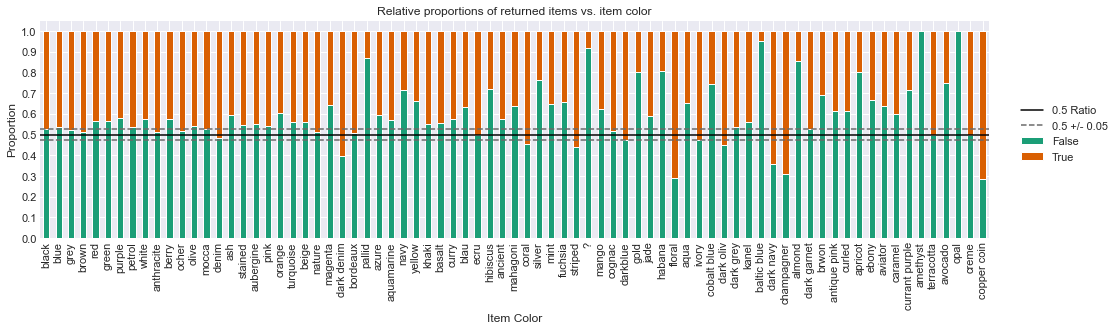

<Figure size 432x288 with 0 Axes>

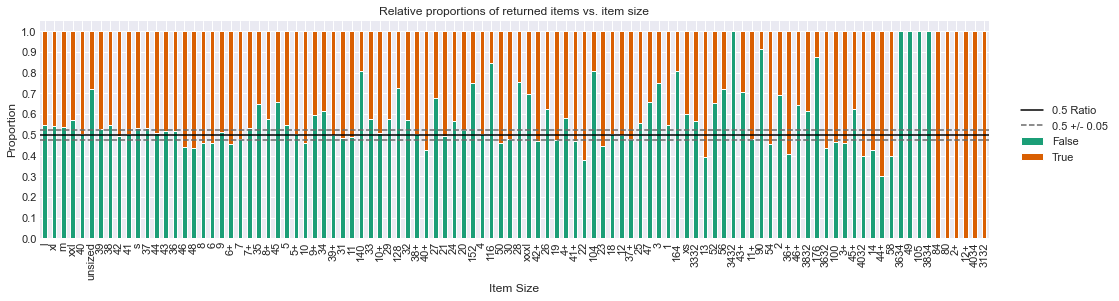

In [276]:
color_rel = data.groupby(['return', 'item_color']).size().reset_index() # Count False/True per category
color_rel = color_rel.pivot(columns='return', index='item_color', values=0)  # coerse to smaller data frame
color_rel = color_rel.reindex(color_rel.iloc[:, 0].sort_values(ascending = False).index) # Sort by number of occurences of the category
color_rel = color_rel.div(np.sum(color_rel, axis = 1).values, axis = 0) # convert absolute number to proportions

plot_1 = plt.figure()
plot_1 = color_rel.plot(kind='bar', stacked = True, figsize = (17, 4), title = "Relative proportions of returned items vs. item color",
              xlabel = "Item Color", ylabel = "Proportion", yticks = np.arange(0, 1.1, step = 0.1), color = my_colors)
plot_1.axhline(y = .5, color = "black", label = "0.5 Ratio")
plot_1.axhline(y = 0.525, color = "dimgrey", linestyle = "--")
plot_1.axhline(y = 0.475, color = "dimgrey", linestyle = "--", label = "0.5 +/- 0.05")
plt.legend(loc = "center", bbox_to_anchor = (0.83, 0.23,  0.5, 0.5))
plt.show()

size_rel = data.groupby(['return', 'item_size']).size().reset_index() # Count False/True per category
size_rel = size_rel.pivot(columns='return', index='item_size', values=0)  # coerse to smaller data frame
size_rel = size_rel.reindex(size_rel.iloc[:, 0].sort_values(ascending = False).index) # Sort by number of occurences of the category
size_rel = size_rel.div(np.sum(size_rel, axis = 1).values, axis = 0) # convert absolute number to proportions

plot_2 = plt.figure()
plot_2 = size_rel.plot(kind='bar', stacked = True, figsize = (17, 4), title = "Relative proportions of returned items vs. item size",
              xlabel = "Item Size", ylabel = "Proportion", yticks = np.arange(0, 1.1, step = 0.1), color = my_colors)
plot_2.axhline(y = .5, color = "black", label = "0.5 Ratio")
plot_2.axhline(y = 0.525, color = "dimgrey", linestyle = "--")
plot_2.axhline(y = 0.475, color = "dimgrey", linestyle = "--", label = "0.5 +/- 0.05")
plt.legend(loc = "center", bbox_to_anchor = (0.83, 0.23,  0.5, 0.5))
plt.show()

As we can see some colors and sizes might have a significant influence on their return probability, e.g. the color *pallid* is only returned in in 10% of the purchases, whereas *champagner* is returned in almost 70% of the purchases in the labeled data set. Interestingly, it seems that the sizes are more homogeneous in a sense that they do not exhibit the same amount of proportionally more returned items as the colors do, except the four sizes that were only returned. Additionally, the most popular sizes are not proportionally more often returned, except *unsized* which, however, does make sense. In section 3 we lay out how we used those ratios to reduce the number of categories without losing too much information. \
Although the plots are ordered in descending order regarding the observations that belong into the respective category, it might still be useful to plot the absolute number of items per category, discriminating between returned and not returned items.

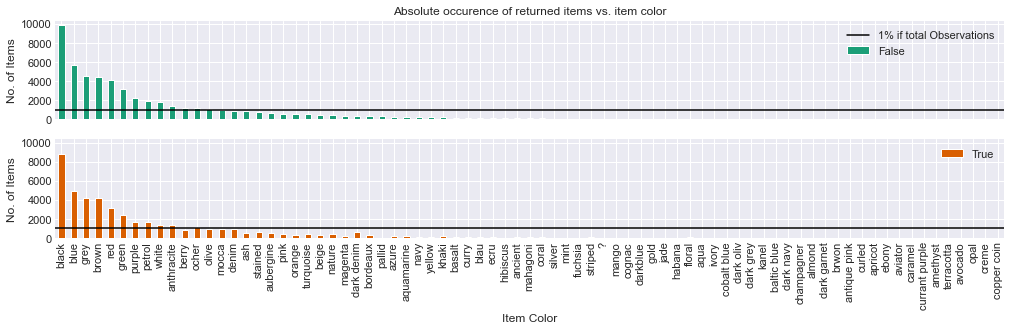

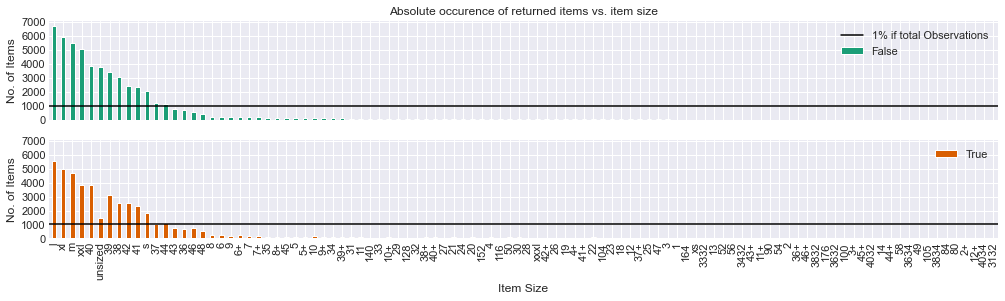

In [277]:
color_abs = data.groupby(['return', 'item_color']).size().reset_index().pivot(columns='return', index='item_color', values=0) # Count False/True per category and coerse to smaller data frame 
color_abs = color_abs.reindex(color_abs.iloc[:, 0].sort_values(ascending = False).index) # Sort by number of occurences of the category
pl_1, pl_2  = color_abs.plot(kind='bar', subplots = True, figsize = (17, 4), title = ["Absolute occurence of returned items vs. item color", ""],
              xlabel = "Item Color", ylabel = "No. of Items", yticks = np.arange(0, 11000, step = 2000), sharey = True, color = my_colors);
pl_1.axhline(y = 1000, color = "black", label = "1% if total Observations")
pl_2.axhline(y = 1000, color = "black", label = "1% if total Observations")
pl_1.legend()
plt.show()

size_abs = data.groupby(['return', 'item_size']).size().reset_index().pivot(columns='return', index='item_size', values=0) # Count False/True per category and coerse to smaller data frame 
size_abs = size_abs.reindex(size_abs.iloc[:, 0].sort_values(ascending = False).index) # Sort by number of occurences of the category
pl_3, pl_4 = size_abs.plot(kind='bar', subplots = True, figsize = (17, 4), title = ["Absolute occurence of returned items vs. item size", ""],
              xlabel = "Item Size", ylabel = "No. of Items", yticks = np.arange(0, 8000, step = 1000), sharey = True, color = my_colors);
pl_3.axhline(y = 1000, color = "black", label = "1% if total Observations")
pl_4.axhline(y = 1000, color = "black", label = "1% if total Observations")
pl_3.legend()
plt.show()

The plot shows that the majority of observation belong to the first ten sizes and colors, however, as we have seen before there is not that much variation in the true false ratio, compared to other sizes and colors. \
Since one can assume that the price plays an important role in the customer's decision process whether she or he returns the item, we might also look at the distribution of *item_price* grouped by the variable *return*.

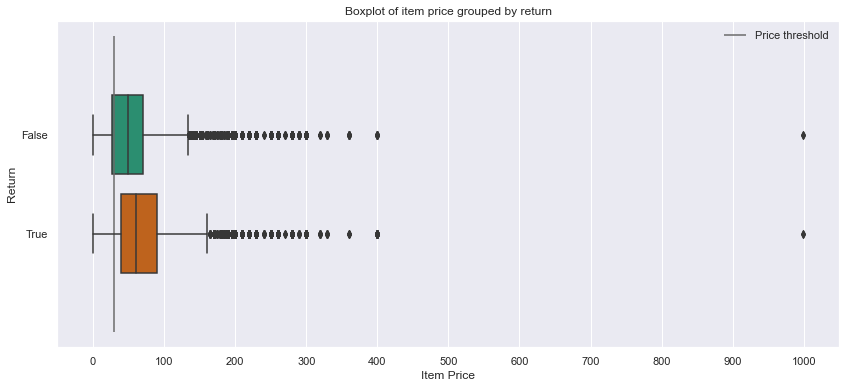

In [278]:
plot_price = data.loc[:, ["return", "item_price"]]

plt.figure(figsize= (14,6))
sns.set_theme(palette = "Dark2")
plot = sns.boxplot(data = plot_price, x = "item_price", y = "return", orient = "h")
plot.set(xlabel = "Item Price", ylabel = "Return", xticks = np.arange(0, 1100, step = 100),
         title = "Boxplot of item price grouped by return")
plot.vlines(x = 30, ymin = -1, ymax = 2, color = "dimgrey", label = "Price threshold")
plt.legend()
plt.show()

We see that the interquartile range of both groups differ from one another, with not returned items being generally of smaller value than returned items, which makes sense because individuals will be more hesitant about keeping an item if its higher priced. However, we also see many outliers for both groups, with item prices that go as high as $1\,000$ EUR. Considering our discussion about the threshold we see that both groups have about 50% of their distribution mass above the price threshold. \
Finally, we might gain more insights into looking into the item price distribution grouped by user title.

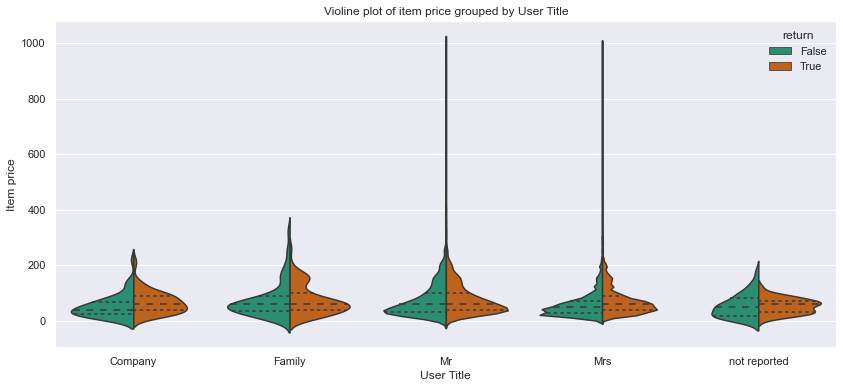

In [279]:
plt.figure(figsize= (14,6))
sns.set_theme(palette = "Dark2")#, palette = "Dark2")
plot = sns.violinplot(x = "user_title", y = "item_price", hue='return',
                           split=True, inner="quart",
                           data= data)
plot.set(xlabel = "User Title", ylabel = "Item price", title = "Violine plot of item price grouped by User Title")
plt.show()

Finally, we add a histogram including a kernel density estimate for the variable *item_price* to check whether our naïve benchmark algorithm $h_{\text{bench}}$ will actually perform good only using the threshold. 

<Figure size 1008x432 with 0 Axes>

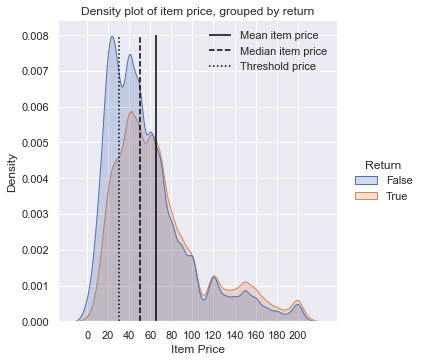

In [280]:
quant_price = data.loc[:, "item_price"].quantile(q = 0.99) # Retrieve 99% uantile of price distribution
price_quant = data[data.item_price < quant_price] # Observations with item prices lower than 99% quantile

#Create Plot
plt.figure(figsize= (14,6))
sns.set_theme(style = "darkgrid")#, palette = "Dark2")
plot = sns.displot(data = price_quant, x = "item_price", hue = "return" , kind = "kde", fill = True)
plt.vlines(data.item_price.mean(), ymin = 0, ymax = 0.008, color = "black", label = "Mean item price")
plt.vlines(data.item_price.median(), ymin = 0, ymax = 0.008, color = "black", linestyles = "dashed", label = "Median item price")
plt.vlines(30, ymin = 0, ymax = 0.008, color = "black", linestyles = "dotted", label = "Threshold price")
plot.set(xlabel = "Item Price", xticks = np.arange(0, quant_price, step = 20),
         title = "Density plot of item price, grouped by return")
plot._legend.set_title("Return")
plt.legend()
plt.show()

We can surmise that the threshold price is much lower then the 50% quantile of the known data set the exact quantile can easily be calculated.

In [281]:
print("%.2f percent of the observations have an item price lower than the threshold." % stats.percentileofscore(data['item_price'],30))

25.36 percent of the observations have an item price lower than the threshold.


We see two things. Firstly, we can probably deduce, that the algorithm $h_{\text{neg}}$ will perform better in terms of the cost matrix than $h_{\text{bench}}$, since there are relatively more items below the threshold that were not returned which could result in higher FP costs for $h_{\text{bench}}$ than the FN costs occurring for $h_{\text{neg}}$ below the threshold (above the threshold both estimators are identical). Secondly, we see that the below the average item price the distribution differ grouped by return differ by size and shape implying that for those items a differentiation is necessary and that even with the threshold in mind any optimal algorithm should be cautious to predict that an item will be returned. This plot also clearly indicates that the item price is a very informative variable and should definitely be included during training. \
In Section 4 we present our approach to circumvent this issue but before that we will discuss our data preperation and feature selection approach in the next section.

# 3. Data Preparation

## 3.1 Variable Transformation

The first issue we have to address is that the model has to be trained and evaluated on a common state space $\mathcal{X}$. However, as we have seen in section 2 there are some item sizes and colors that only appear in either the labeled or in the unlabeled data set, hence we coerce all sizes and colors that only appear in one data set to a new category called *Difference* within the *item_size* and *item_color* variable. In this way we preserve the unique categories and make them still usable for the model.

In [282]:
## Get union of variables of both data sets for size and color
union_size = data["item_size"].cat.categories.sort_values().intersection(data_u["item_size"].cat.categories.sort_values()) # Get the union of all sizes from both datasets
union_col = data["item_color"].cat.categories.sort_values().intersection(data_u["item_color"].cat.categories.sort_values()) # Get the union of all colors from both datasets

## labeled data set
# Size
difference_known = data["item_size"].cat.categories.sort_values().difference(union_size) # Sizes that are only in the labeled data set

if len(difference_known) > 0:
    data["item_size"] = np.where(data['item_size'].isin(difference_known), 'Difference', data['item_size'])
    data["item_size"] = data["item_size"].astype("category")
    print("Known sizes unified.")
else: 
    data["item_size"].cat.add_categories("Difference", inplace = True)
    print("No known sizes to unify.")

# Color
difference_known = data["item_color"].cat.categories.sort_values().difference(union_col) # Colors that are only in the labeled data set

if len(difference_known) > 0:
    data["item_color"] = np.where(data['item_color'].isin(difference_known), 'Difference', data['item_color'])
    data["item_color"] = data["item_color"].astype("category")
    print("Known colors unified.")
else:
    data["item_color"].cat.add_categories("Difference", inplace = True)
    print("No known color to unify.")

## unlabeled data set
# Size
difference_unknown = data_u["item_size"].cat.categories.sort_values().difference(union_size)

if len(difference_unknown) > 0:
    data_u["item_size"] = np.where(data_u['item_size'].isin(difference_unknown), 'Difference', data_u['item_size'])
    data_u["item_size"] = data_u["item_size"].astype("category")
    print("Unknown sizes unified.")
else:
    data_u["item_size"].cat.add_categories("Difference", inplace = True)
    print("No unknown sizes to unify.")

# Color
difference_unknown = data_u["item_color"].cat.categories.sort_values().difference(union_col)

if len(difference_unknown) > 0:
    data_u["item_color"] = np.where(data_u['item_color'].isin(difference_unknown), 'Difference', data_u['item_color'])
    data_u["item_color"] = data_u["item_color"].astype("category")
    print("Unknown color unified.")
else:
    data_u["item_color"].cat.add_categories("Difference", inplace = True)
    print("No unknown colors to unify.")

Known sizes unified.
Known colors unified.
Unknown sizes unified.
No unknown colors to unify.


In the next step we coerce the categories of *item_size* and *item_color* to a category *Other_true* and *Other_false* that either have been all returned or not returned as already depicted in section 2.

In [283]:
# Size
help1 = pd.crosstab(data.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1)
size_f, size_t = help1[help1[0] == 1], help1[help1[1] == 1] # Item sizes where return is either 0 or 1

if len(size_f.index) > 0 or len(size_t.index) > 0:
    data["item_size"] = np.where(data['item_size'].isin(size_t.index), 'Other_true', data['item_size']) # Coerce to new category
    data["item_size"] = np.where(data['item_size'].isin(size_f.index), 'Other_false', data['item_size'])

    # Repeat for unlabeled data set but only use categories identified in the labeled data set
    data_u["item_size"] = np.where(data_u['item_size'].isin(size_t.index), 'Other_true', data_u['item_size']) # Coerce to new category
    data_u["item_size"] = np.where(data_u['item_size'].isin(size_f.index), 'Other_false', data_u['item_size'])
    print("Categories merged.")
else:
    print("No uninformative categories.")

# Color
help1 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)
color_f, color_t = help1[help1[0] == 1], help1[help1[1] == 1] # Item sizes where return is either 0 or 1

if len(color_f.index) > 0 or len(color_t.index) > 0:
    data["item_color"] = np.where(data['item_color'].isin(color_t.index), 'Other_true', data['item_color']) # Coerce to new category
    data["item_color"] = np.where(data['item_color'].isin(color_f.index), 'Other_false', data['item_color'])
    
    # Repeat for unlabeled data set but only use categories identified in the labeled data set
    data_u["item_color"] = np.where(data_u['item_color'].isin(color_t.index), 'Other_true', data_u['item_color']) # Coerce to new category
    data_u["item_color"] = np.where(data_u['item_color'].isin(color_f.index), 'Other_false', data_u['item_color'])
    print("Categories merged.")
else:
    print("No uninformative categories.")

# Convert item_color and item_size back to type category
data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

Categories merged.
No uninformative categories.


As mentioned before, sizes and colors that have an almost 50\% return rate do not provide us with much information. We therefore coerce sizes and colors for which the return rate $r \in [0,1]$ is close to $0.5$ in terms of the Euclidean distance, i.e. a size or color will be coerced to category *Other* if $|r-0.5|< 0.05$. 

In [284]:
# Size
help2 = pd.crosstab(data.item_size, data["return"]).apply(lambda r: r/r.sum(), axis=1) # Calculate return ratio for each category

threshold_percent = 0.05 # Define threshold
series = pd.value_counts(data['item_size']) # Get categories
mask = (help2[0]-help2[1]).abs().lt(threshold_percent) # Masking Series, ratio smaller then threshold
data["item_size"] = np.where(data['item_size'].isin(series[mask].index),
                             'Other', data['item_size']) # Reset every categeory that is in mask to Other, else leave unchanged
data_u["item_size"] = np.where(data_u['item_size'].isin(series[mask].index), 'Other', data_u['item_size']) # Same for the unlabeled data set

data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

# Color
help2 = pd.crosstab(data.item_color, data["return"]).apply(lambda r: r/r.sum(), axis=1)

threshold_percent = 0.05
series = pd.value_counts(data['item_color'])
mask = (help2[0]-help2[1]).abs().lt(threshold_percent)
data["item_color"] = np.where(data['item_color'].isin(series[mask].index), 'Other', data['item_color'])
data_u["item_color"] = np.where(data_u['item_color'].isin(series[mask].index), 'Other', data_u['item_color'])

data[filter_cat] = data[filter_cat].astype("category")
data_u[filter_cat] = data_u[filter_cat].astype("category")

These steps lead to the following reduction in the number of unique size and color categories and the following numbers of categories remain.

In [285]:
og_data[filter_cat] = og_data[filter_cat].astype("category") # convert original size and color variables to type category for the labeled data set
og_data_u[filter_cat] = og_data_u[filter_cat].astype("category") # convert original size and color variables to type category for the unlabeled data set

# calculate differences and save current number of unique categories for both variables and data sets
known_diff = og_data.loc[:, ["item_size", "item_color"]].nunique()-data.loc[:, ["item_size", "item_color"]].nunique()
unknown_diff = og_data_u.loc[:, ["item_size", "item_color"]].nunique()-data_u.loc[:, ["item_size", "item_color"]].nunique()
known_remain = data.loc[:, ["item_size", "item_color"]].nunique()
unknown_remain = data_u.loc[:, ["item_size", "item_color"]].nunique()

# Display in Table
pd.DataFrame(data = {"Labeled Difference" : known_diff, "Unlabeled Difference" : unknown_diff,
                     "Remaining Labeled" : known_remain, "Remaining Unlabeled" : unknown_remain})

,Labeled Difference,Unlabeled Difference,Remaining Labeled,Remaining Unlabeled
item_size,30,31,72,72
item_color,19,10,58,57


Besides the category variables we also exhibit variables of type *datetime*, namely *order_date*, *delivery_date*, *user_reg_date* and *user_dob*. These variables are not ad hoc usable in our model so we have to convert them to usable variables without reducing their information value. \
For the variables *order_date* and *delivery_date* we create therefore a new variable that is called *time_to_delivery* in which the days between the order and delivery date are stored. The reasoning behind this is that customers might be more critical in their decision process on whether to return an item depending on the time it took to be delivered. For example, when a package takes more than 3 days to arrive a customer might be more hesitant to return the item because he or she already waited quite a long time for it to arrive in the first place. This converts the date variables to a numeric variable which can easily be used by the model. Furthermore, we also display some statistics of the new variable. \
Additionally, after some exploration we identified an irregular entry of delivery dates. The date "1994-12-31" showed up in 1072 rows but the earliest order date is not before 2007. Hence, some data must have been corrupted so that this date was hard coded into the data set instead of a missing value. We cannot determine the concrete reason for this (e.g. item wasn't delivered, delivery date could not be tracked) and for this reason we dropped the observations from our dataset. We also display the return ratios for those observations which seems to include more information but again we cannot determine the exact reason for this date entry hence we cannot justify any value for those entries in the new variable *time_to_delivery*. 

In [286]:
miss_date = data[data["delivery_date"] == "1994-12-31"] # Retrieve observations where the delivery dae is corrupted
tab = pd.crosstab(miss_date["delivery_date"], miss_date["return"]).apply(lambda r: r/r.sum(), axis=1) # Create table with return ratio for those observations
tab["Obs"] = miss_date.shape[0] # Add number of observations to table
tab # Display table

return,False,True,Obs
delivery_date,,,
1994-12-31,0.624067,0.375933,1072


In [287]:
# Create new time_to_delivery variable
data = data[data["delivery_date"] != "1994-12-31"] # Omit corrupted delivery date observations
data["time_to_delivery"] = (data["delivery_date"]-data["order_date"]).dt.days # Calculate days between order date and delivery date
data.time_to_delivery.describe() # Display summary statistics

count    89610.000000
mean         7.401685
std         13.492619
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        173.000000
Name: time_to_delivery, dtype: float64

In the next step we create a new variable *user_age* from the *user_dob* variable which is just the age of the individual in days. 

In [288]:
t1 = data["user_dob"] 
t2 = datetime.now() 
data["user_age"] = (t2-t1).dt.days

Next, we create a new variable *customer_age* which depicts the number of days that user has been registered on the platform. We use the maximum value of *user_reg_date* plus one as the current date for calculating the age of the user account. The reasoning is that regular customers are probably more experienced and will therefore be better in reckoning beforehand if they will return the item. This can also be inferred from the following crosstab. 

In [289]:
# Create new customer_age variable
t1 = data["user_reg_date"]
t2 = data["user_reg_date"].max() + timedelta(days = 1)

data["customer_age"] = (t2-t1).dt.days

# Display return ratios for customer_age groups
tab_data = data.copy() 
tab_data["cust_brack"] = [np.nan for i in range(len(tab_data.index))] # Create new variable filled with NAs

# Create identifiers which depict whether an account is fairly new (< 50 days), seasoned ( >= 50, < 200) or old ( >= 200) in the new variable
tab_data.loc[tab_data["customer_age"] < 20, "cust_brack"] = "new" 
tab_data.loc[(tab_data["customer_age"] >= 20) & (tab_data["customer_age"] < 200), "cust_brack"] = "seasoned"
tab_data.loc[tab_data["customer_age"] > 200, "cust_brack"] = "old"
tab_data["cust_brack"] = tab_data["cust_brack"].astype("category") # Convert to category
tab = pd.crosstab(tab_data["cust_brack"], tab_data["return"]).apply(lambda r: r/r.sum(), axis=1) # Calculate return ratios per category
tab["Obs"] = tab_data.groupby("cust_brack")["cust_brack"].count() # Add Observations for each category
tab # Display table

return,False,True,Obs
cust_brack,,,
new,0.542601,0.457399,5575
old,0.531764,0.468236,58210
seasoned,0.556327,0.443673,34868


Finally, we repeat the transformations for the unlabeled data set and delete the old datetime variables.

In [154]:
# Repeat for unlabeled data

# Create time_to_delivery
data_u["time_to_delivery"] = (data_u["delivery_date"]-data_u["order_date"]).dt.days

# Create user_age
t1 = data_u["user_dob"]
t2 = datetime.now()
data_u["user_age"] = (t2-t1).dt.days

# Create customer_age 
t1 = data_u["user_reg_date"]
t2 = data_u["user_reg_date"].max() + timedelta(days = 1)
data_u["customer_age"] = (t2-t1).dt.days

# Delete old datetime variables 
data = data.drop(labels = ["order_date", "delivery_date", "user_dob", "user_reg_date"], axis = 1)
data_u = data_u.drop(labels = ["order_date", "delivery_date", "user_dob", "user_reg_date"], axis = 1)

## 3.2 Feature selection

Since all variables have now been tackled appropriately such that they can be used by our model we can make decision about which features we should include. One could argue that we should include all features to make full use of our data set, however, this results in a very complex model that might not be able to perform well on new unseen data (see for example [Occam’s Razor]( https://en.wikipedia.org/wiki/Occam%27s_razor)), since we have to convert all category variables by one-hot encoding (otherwise the model will be unable to interpret those variables). This is an issue for the variables *item_color* and *item_size* which would currently result in more than 128 additional variables. We could carefully select features by some self-developed ranking system to retrieve those features that, according to our subjective ranking, have the most information regarding the return variable, but this is fairly complex and prone to result in a non-optimal selection. Since we already know which model we will use and the cost matrix, we could turn to an automated feature selection approach like using the $\chi^2$ test statistic of the independence test with the same name to select only features that are not statistically independent of the target variable. Since we use a boosted classification tree model, we decided to use cross-validated recursive feature elimination based on feature importance and a subjective approach where we include some features regardless of the suggestion of the algorithm. Before we further explain how this approach works, we will convert all variables of type *category* via one-hot encoding. 

In [156]:
backup = data.copy()
backup_u = data_u.copy()

dummies = pd.get_dummies(data.select_dtypes("category"))
dummies_u = pd.get_dummies(data_u.select_dtypes("category"))
backup = backup.drop(labels = data.select_dtypes("category").columns, axis = 1)
backup_u = backup_u.drop(labels = data_u.select_dtypes("category").columns, axis = 1)
backup = pd.concat([backup, dummies], axis = 1)
backup_u = pd.concat([backup_u, dummies_u], axis = 1)

data_fs = backup
data_u_fs = backup_u

Now let us shortly explain the idea of the feature selection process. Firstly, fit a boosted tree model to the data using all features. Secondly, calculate the feature importance. Thirdly, predict the target variable with the fitted model and calculate the expected costs using our cost matrix and save the result. Fourthly, select the features whose feature importance is in the 10% percentile or the lowest scoring five features, whichever is greater and discard those features from the data set. This procedure is repeated several times until there is no significant reduction in the expected costs or there are no more features to select from. In our case training and prediction is done using stratified 10-fold cross-validation and features are additionally ranked between the folds to determine the ones that will be eliminated. \
Note that we only use the category variables *item_size*, *item_color* and *user_state* for the selection process since the other variables should be informative already or they do not have many categories to begin with. Additionally, keep in mind that we used a 40-kernel server for calculations and this process is in itself very time demanding.

In [194]:
X, y = data_fs.drop(labels = ["return", "time_to_delivery", "user_age", "customer_age",
                              'user_title_Company', 'user_title_Family', 'user_title_Mr','user_title_Mrs',
                              'user_title_not reported'], axis = 1), data_fs.loc[:, "return"] # Split data set into features and response and drop variables that will be selected regardless
clf = GradientBoostingClassifier(n_estimators = 100, loss = "deviance", random_state = 314, verbose = 0) # Intantiate boosted classification tree

In [181]:
# Create scoring function from cost matrix
def cost_custom_score_feat(estimator, X, y):
    zeros = np.zeros(y.shape[0])
    hat = 1 * estimator.predict(X)
    val = X[:, 2]
    score = np.fmax(np.array(y - hat), zeros) * (5/2) * (3 + 0.1 * val) + np.fmax(np.array(hat - y), zeros) * (0.5 * val)
    return score.sum()
cost_score_feat = metrics.make_scorer(cost_custom_score_feat, greater_is_better = False)

Actual feature selection using 10-fold stratified cross-validation with custom scoring as evaluation scoring.

In [433]:
min_selection = 5
rfecv = RFECV(estimator = clf, step = 0.1, verbose = 2, min_features_to_select = min_selection,
              cv = StratifiedKFold(10), scoring = cost_score_feat, n_jobs = -1)
rfecv.fit(X, y)

Fitting estimator with 156 features.
      Iter       Train Loss   Remaining Time 
         1           1.3731           40.93s
         2           1.3677           40.42s
         3           1.3632           40.16s
         4           1.3594           39.88s
         5           1.3563           39.44s
         6           1.3537           39.02s
         7           1.3514           38.59s
         8           1.3494           38.14s
         9           1.3478           37.68s
        10           1.3463           37.23s
        20           1.3376           33.05s
        30           1.3337           28.73s
        40           1.3309           24.43s
        50           1.3284           20.24s
        60           1.3264           16.09s
        70           1.3238           12.05s
        80           1.3222            8.00s
        90           1.3209            3.98s
       100           1.3188            0.00s
Fitting estimator with 141 features.
      Iter       Train Lo

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(random_state=314, verbose=1),
      min_features_to_select=5, n_jobs=-1,
      scoring=<function cost_custom_score_feat at 0x000000BF0F276C10>, step=0.1,
      verbose=2)

We will save the model to the disk in case we need to reuse it. 

In [484]:
dump(rfecv, 'feat_selector.joblib') 

['feat_selector.joblib']

If trained on Server, load RFECV object.

In [182]:
# If trained on server: Server = 1
Server = 1

if Server == 1:
    rfecv = load('feat_selector.joblib')
    print("Loaded instance of rfecv.")
else:
    print("Instance is already loaded.")

Loaded instance of rfecv.


D:\Program Files\Anaconda\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Program Files\Anaconda\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Program Files\Anaconda\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RFECV from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Beside the optimal number of features, we can also display the results of the selection process.

Optimal number of features : 6


NameError: name 'min_selection' is not defined

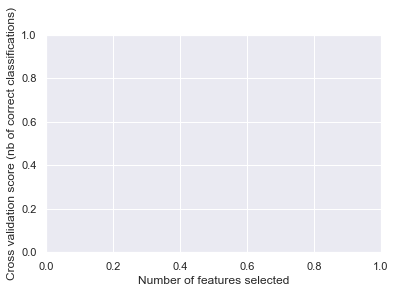

In [193]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_selection,
               len(rfecv.grid_scores_) + min_selection),
         rfecv.grid_scores_)
plt.show()

We save the features that will *not* be selected in a variable for later. We display, however, the features that were selected.

In [233]:
drop_vars = X.loc[:, ~rfecv.get_support()].columns # Save variables to be dropped
vars_selected = X.loc[:, rfecv.get_support()].columns.values.tolist() + list(["return", "time_to_delivery", "user_age", "customer_age",
                                                                                     'user_title_Company', 'user_title_Family',
                                                                                     'user_title_Mr','user_title_Mrs','user_title_not reported'])
pd.Series(vars_selected)

0                     item_id
1                    brand_id
2                  item_price
3                     user_id
4                customer_age
5           item_size_unsized
6                      return
7            time_to_delivery
8                    user_age
9                customer_age
10         user_title_Company
11          user_title_Family
12              user_title_Mr
13             user_title_Mrs
14    user_title_not reported
dtype: object

Finally, we save the cleaned and transformed data before the feature selection and transform the data set again via one-hot encoding to be able to drop the features that were deemed unimportant for our model. 

In [261]:
# Save cleaned and transformed data without one-hot encoding
data.to_pickle('./data/known_cleaned_wo_dummies')
data_u.to_pickle('./data/unknown_cleaned_wo_dummies')

## Transform data set via one-hot encoding
# labeled data
backup = data.copy()
dummies = pd.get_dummies(data.select_dtypes("category"))
backup = backup.drop(labels = data.select_dtypes("category").columns, axis = 1)
backup = pd.concat([backup, dummies], axis = 1)

# unlabeled data
backup_u = data_u.copy()
dummies_u = pd.get_dummies(data_u.select_dtypes("category"))
backup_u = backup_u.drop(labels = data_u.select_dtypes("category").columns, axis = 1)
backup_u = pd.concat([backup_u, dummies_u], axis = 1)

Next, we drop the variables and in the last step we make sure that the labeled and unlabeled data set have the same features in the same order. Note that since there were no colors that only appeared in the unlabeled data set, we must account for this when dropping the variables.

In [262]:
## Discard the features that were not selected
backup = backup.drop(labels = drop_vars, axis = 1)
backup_u = backup_u.drop(labels = drop_vars[drop_vars != "item_color_Difference"], axis = 1)

## Making sure that both data sets have the same features, note that we subtract by one to account for the variable return
difference_feat = abs(backup.shape[1]-1 - backup_u.shape[1])

if difference_feat != 0:
    columns_lab = backup.columns[backup.columns != "return"] # Get column names in labeled data set, except return
    columns_not_in = [x for x in backup_u.columns if x not in columns_lab] # Get column names that are only in the unlabeled data set
    backup_u = backup_u.loc[:, columns_lab.values.tolist()] # subset the labeled data set to only contain the features of the labeled data set
    print("The following columns were discarded from the unlabeled data set: %s" %columns_not_in)
else:
    print("The features of both data sets are equal.")

The features of both data sets are equal.


Finally, rearrange the variables so that the order of the unknown data set matches the order of the known data set and save both data sets.

In [444]:
help2 = backup.columns[backup.columns != "return"] # Get order of columns of labeled data set
backup_u = backup_u[help2] # Reorder unlabeled data set

backup.to_pickle('./data/known_cleaned_w_dummies') # Save labeled data set with one-hot encoding
backup_u.to_pickle('./data/unknown_cleaned_w_dummies') # Save unlabeled data set with one-hot encoding

In the next section we will detail the model selection and tuning process.

# 4. Model Tuning and Selection

Load data, could be omitted

In [446]:
data = pd.read_pickle('./data/known_cleaned_w_dummies')
X = data.drop("return", axis = 1)
y = data["return"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 1 to 100000
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            98928 non-null  int64  
 1   brand_id           98928 non-null  int64  
 2   item_price         98928 non-null  float64
 3   user_id            98928 non-null  int64  
 4   time_to_delivery   89610 non-null  float64
 5   user_age           90292 non-null  float64
 6   customer_age       98928 non-null  int64  
 7   item_size_unsized  98928 non-null  uint8  
dtypes: float64(3), int64(4), uint8(1)
memory usage: 6.1 MB


### Create test and train sets based on the known dataset via random splitting

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 314)

### Define custom evaluation score for tuning (might be omitted) and custom evaluation function using provided cost matrix 

In [448]:
def cost_custom_score(estimator, X, y):
    zeros = np.zeros(y.shape[0])
    hat = 1 * estimator.predict(X)
    val = X.loc[:, "item_price"]
    score = np.fmax(np.array(y - hat), zeros) * (5/2) * (3 + 0.1 * val) +
                 np.fmax(np.array(hat - y), zeros) * (0.5 * val)
    return score.sum()
cost_score = make_scorer(cost_custom_score, greater_is_better = False)

In [449]:
def cost_custom_eval(y_true, y_test, X, relative = False):
    '''Custom Evaluation based on cost matrix
    relative: True: return TP, FP, FN, TN, False: return the aggregated score, i.e. TP + TN + FP + FN
    '''
    y_true = 1 * y_true # Convert to integer
    y_test = 1 * y_test
    
    zeros = np.zeros(y_true.shape[0]) # zeros for calculation
    val = X.loc[:, "item_price"] # item_price of item 
    
    TP, TN = np.array([0, 0]) # TP and TN are always 0
    
    # Calculate FP
    FP = np.fmax(np.array(y_test - y_true), zeros) * (0.5 * val)
    
    # Calculate FN
    FN = np.fmax(np.array(y_true - y_test), zeros) * (5/2) * (3 + 0.1 * val)
    
    # If clause for relative parameter
    if(relative == True):
        return(np.array([TP, FP.sum(), FN.sum(), TN]))
    else:
        return(np.sum([FP, FN]))
    
    #score = 1 * (np.fmax(np.array(y_true - y_test), zeros) * (0.5 + 0.1 * val) +
    #             np.fmax(np.array(y_test - y_true), zeros) * (0.5 * val))
    #return score.sum()

### Reference Model Performance

In [450]:
# Train a simple boosted tree classifier and calculate the custom score for this model using the X_test and y_test hold out
ref_mod = xgb.XGBClassifier(objective = "binary:logistic")
ref_mod.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=40, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [451]:
base_perf = cost_custom_eval(y_test, 1 * ref_mod.predict(X_test), X_test)
base_perf

316657.06249999994

### Cross-Validation Tuning

In [452]:
fixed_boosting_rnds = True # Implemented a switch whether number of boosting rounds shoul be tuned as well
param_grid = {"max_depth" : np.arange(1,80, step = 5), # maximum number of nodes for each base learner
             "eta" : stats.uniform(0.01, 0.80), # Learning rate
             "gamma" : stats.uniform(0.01, 3), # Minimum node impurity gain required to attempt a split
             "lambda" : stats.uniform(0, 8), # L2 regularization coefficent
             "colsample_bytree" : np.arange(0.1, 1, step = 0.1), # proportion of features considered for each base learner
             "subsample" : np.arange(0.2, 1, step = 0.1), # proportion of training data subsampled for each base learner
             "n_estimators" : np.where(fixed_boosting_rnds, 50, np.arange(10, 40, step = 5))} # Number of boosting rounds; will be inreased for the winner
    
gbm = xgb.XGBClassifier(objective = "binary:logistic") # initiate estimator
metric = cost_score # Scoring metric used during training
n = 600 # number of candidates to consider
fold = 5 # number of folds for cv
print("The total number of fits is: %d" % (n * fold)) # number of fits

The total number of fits is: 3000


In [453]:
randomized_auc = RandomizedSearchCV(estimator = gbm, n_iter = n, cv = fold, scoring = metric,
                                    param_distributions = param_grid, verbose = 1, random_state = 321,
                                   n_jobs = -1, refit = True)
randomized_auc.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 81.9min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 163.9min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed: 285.9min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed: 428.4min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed: 583.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 732.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000BF0683F940>,
                                        'lambda': <scipy

In [454]:
print("Best Parameters:", randomized_auc.best_params_)
print("Best Score:", randomized_auc.best_score_ * (-1))

Best Parameters: {'colsample_bytree': 0.1, 'eta': 0.7798569516942158, 'gamma': 1.3955090095398668, 'lambda': 0.34561831144949196, 'max_depth': 66, 'n_estimators': 50, 'subsample': 0.9000000000000001}
Best Score: 134339.6315


Save model object to disk.

In [500]:
dump(randomized_auc, 'tuned_model.joblib')

['tuned_model.joblib']

If trained on server:

In [507]:
#Trained on server: switch = 1
switch = 1
param_server = np.where(switch == 0, ["eta", "lambda"], ["learning_rate", "reg_lambda"])

if(switch == 1):
    randomized_auc = load("tuned_model.joblib")
    params = randomized_auc.get_params()
else:
    # copy paste saved dictionary if not on server
    params = randomized_auc.best_params_
eval_set = [(X_train, y_train), (X_test, y_test)] # Evaluation set for early stopping

randomized_auc = xgb.XGBClassifier(objective = "binary:logistic",
                                   max_depth = params["max_depth"],
                                   learning_rate =  params[param_server[0]],
                                   gamma = params["gamma"],
                                   reg_lambda = params[param_server[1]],
                                   colsample_bytree = params["colsample_bytree"],
                                   subsample = params["subsample"],
                                   n_estimators = 500, # Train with higher number of boosting rounds as in the cv part
                                   random_state = 321)
randomized_auc.fit(X_train, y_train, early_stopping_rounds = 20, eval_metric = "aucpr", eval_set = eval_set,
                  verbose = True) # Enable earlier stopping when within 10 rounds no improvement is observed using auc as evaluation metric

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.52616	validation_1-aucpr:0.52733
[1]	validation_0-aucpr:0.66199	validation_1-aucpr:0.62684
[2]	validation_0-aucpr:0.75932	validation_1-aucpr:0.65544
[3]	validation_0-aucpr:0.75843	validation_1-aucpr:0.65857
[4]	validation_0-aucpr:0.75831	validation_1-aucpr:0.65956
[5]	validation_0-aucpr:0.75783	validation_1-aucpr:0.65981
[6]	validation_0-aucpr:0.76249	validation_1-aucpr:0.66161
[7]	validation_0-aucpr:0.76359	validation_1-aucpr:0.66181
[8]	validation_0-aucpr:0.76507	validation_1-aucpr:0.66414
[9]	validation_0-aucpr:0.76544	validation_1-aucpr:0.66459
[10]	validation_0-aucpr:0.76552	validation_1-aucpr:0.66475
[11]	validation_0-aucpr:0.76537	validation_1-aucpr:0.66502
[12]	validation_0-aucpr:0.76533	validation_1-aucpr:0.66505
[13]	validation_0-aucpr:0.82416	validation_1-aucpr:0.68360
[14]	validation_0-aucpr:0.83084	validation_1-aucpr:0.68441
[15]	validation_0-aucpr:0.83091	validation_1-aucpr:0.68461
[16]	validation_0-aucpr:0.83091	validation_1-aucpr:0.68461
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1,
              gamma=1.3955090095398668, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.7798569516942158,
              max_delta_step=0, max_depth=66, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, random_state=321, reg_alpha=0,
              reg_lambda=0.34561831144949196, scale_pos_weight=1,
              subsample=0.9000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [456]:
randomized_auc.best_iteration, randomized_auc.best_score

(84, 0.692797)

Display evaluation performance during fitting with optional stopping.

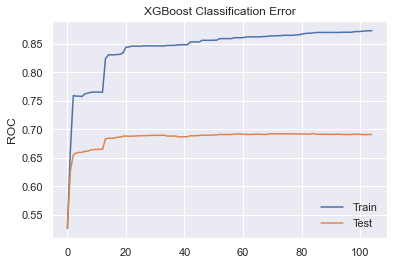

In [457]:
from matplotlib import pyplot
results = randomized_auc.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
# plot roc
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
pyplot.ylabel('ROC')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### Find optimal cost-cutoff

First let us inspect, whether our model is well calibrated.

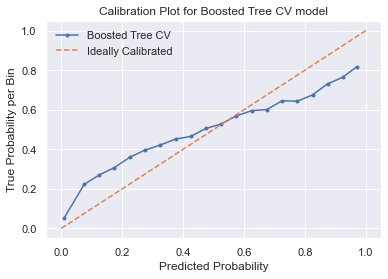

In [458]:
# Calibration curve for LogitCV
from sklearn.calibration import calibration_curve

# Get prediction probabilities
pred_proba = randomized_auc.predict_proba(X_test)[:,1]

# Calculate calibration using calibration_curve function
prob_true, prob_pred = calibration_curve(y_test, pred_proba, n_bins = 20)

# Plot results
plt.plot(prob_pred, prob_true, marker = '.', label = 'Boosted Tree CV')  
plt.title("Calibration Plot for Boosted Tree CV model")
plt.ylabel("True Probability per Bin")
plt.xlabel("Predicted Probability") 
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated'); 
plt.legend();

Next we do the following: Using cross-validation we employ a greedy algorithm to find optimal cost_cutoff for our model. As discussed early, the costs for FP are generally higher than the costs for FN therefore we will only display and return the cost-optimal cutoffs and not calculate a mean of those.

In [459]:
# Save function to calculate error-cost including option to adjust cutoff
def calc_error_cost(y_probabilities, y_test, cutoff, X):
    pred = np.where(y_probabilities >= cutoff, 1, 0)                    # convert class probabilities into class predictions
    cost = cost_custom_eval(y_test, pred, X)  # calculate the corresponding cost
    return [cutoff, cost]

In [460]:
def cv_split(seq, splits):
      return (seq[i::splits] for i in range(splits))

# Define function for threshold tuning
def lowest_error_cutoff(k, X_train_df, y_train_true, estimator):
    cutoffs_total = [] # save best cutoff from each split here, so we can average this cutoff later

    # Create a list of the index of our full data set as input, and k for the amount of splits
    cv_split_list = list(cv_split(shuffle(X_train_df.index.values.tolist(), random_state=888), k)) 

    for fold, i in enumerate(cv_split_list): # for each split 

        temp = X_train_df.index.isin(i) # Create temp variable for data to exclude            
        X_train_cv, y_train_cv = X_train_df.iloc[~temp], y_train_true[~temp] # Build model on all but hold out data
        X_test_cv, y_test_cv =  X_train_df.iloc[temp], y_train_true[temp] # Test on hold out data later
        estimator.fit(X_train_cv, y_train_cv.ravel()) # Train model
        pred_temp_prob = estimator.predict_proba(X_test_cv)[:, 1] # Calculate class probabilities for current split

        # Define empty variable to save all cutoffs and corresponding errors. This way we can extract the lowest one for this split later
        cutoffs_cv = []
        error_cost_cv = []

        for j in  np.arange(0, 1, 0.001): # np.arrange(from, to, step-size)
            #pred_temp = (pred_temp_prob >= j).astype(bool) # convert probabilities to class predictions
            cutoffs_cv.append(j) # save corresponding cutoff
            temp_cutoff_cost = calc_error_cost(pred_temp_prob, y_test_cv, j, X_test_cv) # calculate cost and cutoff using our previously function
            error_cost_cv.append(temp_cutoff_cost[1]) # save error for the given cutoff

        temp_df = pd.DataFrame({"cutoffs":cutoffs_cv, "error_cost": error_cost_cv}).sort_values("error_cost")  # merge cutoffs and error cost, sort from lowest to highest by error_cost
        print("This is the fold number {}".format(fold+1)," of the cross-validation")
        print("The lowest error on the holdout data was achieved with the following cut-off: {}".format(temp_df.iloc[0].values[0]))
        print("The corresponding error cost is: {}".format(temp_df.iloc[0].values[1]))
        print("")
        cutoffs_total.append(temp_df.iloc[0, 0]) # save the lowest cutoff of this split to the list so we can average it at the end
        plt.plot(temp_df.cutoffs, temp_df.error_cost) # plot cutoffs and corresponding errors
    return(cutoffs_total)


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 1  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.687
The corresponding error cost is: 64967.09500000001

[02:07:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


This is the fold number 2  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.613
The corresponding error cost is: 64471.91000000001



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 3  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.595
The corresponding error cost is: 67119.3025

[02:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


This is the fold number 4  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.625
The corresponding error cost is: 63671.030000000006



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 5  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.53
The corresponding error cost is: 62864.795000000006



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 6  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.631
The corresponding error cost is: 64989.6225



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:48:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 7  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.517
The corresponding error cost is: 67053.2625



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 8  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.664
The corresponding error cost is: 65047.78



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:00:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 9  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.5720000000000001
The corresponding error cost is: 63873.0825

[03:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


This is the fold number 10  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.644
The corresponding error cost is: 64716.52250000001



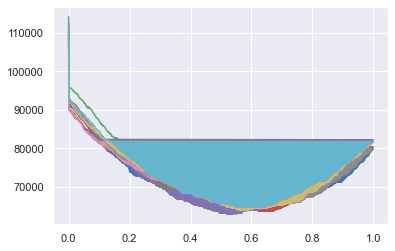

In [461]:
cutoff_candidates = lowest_error_cutoff(10, X_train, y_train, randomized_auc) # Calculate optimal cutoff candidates via 5-fold CV

# Since FP < FN for almost all items (except the ones with item_price = 0) select the 0.75 quantile of the cutoffs 
#cutoff_opt = np.quantile(cutoff_candidates, 0.75)
cutoff_opt = np.mean(cutoff_candidates) # Cutoff via mean

# Calculate predictions on test set
preds = np.where(randomized_auc.predict_proba(X_test)[:, 1] >= cutoff_opt, 1, 0)

Return feature importance of tuned model

In [462]:
quant = pd.Series(randomized_auc.feature_importances_,
                  index = X_train.columns).sort_values(ascending = False).quantile(q = 0.7) # get 70% quantile
importance_trained = pd.Series(randomized_auc.feature_importances_, index = X_train.columns).sort_values(ascending = False)
importance_trained[importance_trained >= quant] # Display only the 30% highest importance values

time_to_delivery     0.605191
item_size_unsized    0.216156
item_price           0.067911
dtype: float32

In [463]:
quant = pd.Series(randomized_auc.feature_importances_,
                  index = X_train.columns).sort_values(ascending = False).quantile(q = 0.3) # get 70% quantile
importance_trained = pd.Series(randomized_auc.feature_importances_, index = X_train.columns).sort_values(ascending = False)
importance_trained[importance_trained < quant] # Display only the 30% lowest importance values

brand_id        0.022600
user_age        0.017101
customer_age    0.016589
dtype: float32

Save AUC score and custom score into .txt file

In [464]:
perf_auc = metrics.roc_auc_score(y_test, preds)
perf_cust = cost_custom_eval(y_test, 1 * preds, X_test)
sys_time = datetime.now().strftime("%d-%b-%Y (%H:%M)")

In [465]:
%%script false --no-raise-error
# Initiate .txt and column header, is run once
f = open("results_RS.txt", "w+")
file = open("results_RS.txt", "a")
file.write("\t".join(["Time", "\t\t AUC", "\t Custom Score", "\t Cutoff", "\n"]))
file.close()

Couldn't find program: 'false'


In [466]:
file = open("results_RS.txt", "a")
file.write(" ".join([sys_time,"\t", str(perf_auc.round(5)),"\t", str(perf_cust.round(5)), "\t\t", str(cutoff_opt.round(5)), "\n"]))
file.close()

Display best parameters and best score during training

In [467]:
print("Best Parameters:", randomized_auc.get_params())

Best Parameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.1, 'gamma': 1.3955090095398668, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.7798569516942158, 'max_delta_step': 0, 'max_depth': 66, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 40, 'num_parallel_tree': 1, 'random_state': 321, 'reg_alpha': 0, 'reg_lambda': 0.34561831144949196, 'scale_pos_weight': 1, 'subsample': 0.9000000000000001, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


Save hyperparameters inside a .txt file

In [468]:
%%script false --no-raise-error
# Initiate .txt and column header, is run once
f = open("hyperparams.txt", "w+")
file = open("hyperparams.txt", "a")
file.write("Hyperparameters in Dictionary format \n")
file.close()

Couldn't find program: 'false'


In [469]:
file = open("hyperparams.txt", "a")
file.write("\t".join([sys_time, str(randomized_auc.get_params()), "\n"]))
file.close()

# 5. Model Evaluation

Display custom score using the tuned model and the hold out test set and compare with base performance using the found cutoff. Furthermore, we include an algorithm that classifies all items as non-return items, all items with $price<30$ as a return and all items with $price \geq 30$ as a non-return and an algorithm that treats the target variable $y_i$ as Bernoulli distributed random variable with $p = 0.5$.

In [470]:
# Classifier with price based decision rule
def benchmark_algo(X):
    prices = X["item_price"]
    preds = np.zeros(prices.shape[0])
    preds = np.where(prices < 30, 1, 0)
    return(preds)
preds_bench = benchmark_algo(X_test)

In [471]:
print("Tuned Custom Evaluation Score:", cost_custom_eval(y_test, 1 * preds, X_test).round(5))
print("Tuned AUC score:", metrics.roc_auc_score(y_test, preds).round(5))
print("Base Custom Evaluation Score:", base_perf.round(5))
print("Base AUC Score:", metrics.roc_auc_score(y_test, ref_mod.predict(X_test)).round(5))
print("Monkey Custom Evaluation Score:", cost_custom_eval(y_test, 1* random.choices(np.array([True, False]), k = y_test.shape[0]), X_test).round(5))
print("Monkey AUC Score:", metrics.roc_auc_score(y_test, random.choices(np.array([True, False]), k = y_test.shape[0])).round(5))
print("All negative Custom Evaluation Score:", cost_custom_eval(y_test, np.zeros(len(y_test)), X_test).round(5))
print("All negative AUC Score:", metrics.roc_auc_score(y_test, np.zeros(len(y_test))).round(5))
print("Benchmark Custom Evalutation Score:", cost_custom_eval(y_test, preds_bench, X_test).round(5))
print("Benchmark AUC Score:", metrics.roc_auc_score(y_test, preds_bench).round(5))

Tuned Custom Evaluation Score: 279790.09
Tuned AUC score: 0.65992
Base Custom Evaluation Score: 316657.0625
Base AUC Score: 0.65637
Monkey Custom Evaluation Score: 405969.905
Monkey AUC Score: 0.49642
All negative Custom Evaluation Score: 352653.855
All negative AUC Score: 0.5
Benchmark Custom Evalutation Score: 371882.415
Benchmark AUC Score: 0.43284


Create Confusion matrix with probabilites and a custom confusion matrix based on the cost matrix

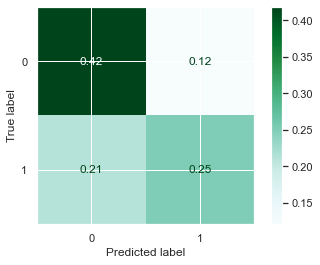

In [489]:
conf_matrix_preds = metrics.confusion_matrix(y_test, preds, normalize = "all")
metrics.ConfusionMatrixDisplay(conf_matrix_preds).plot(cmap = plt.cm.BuGn, values_format = ".2f")

In [490]:
def cust_confusion_matrix(y_true, y_pred, X, normalize = True, rnd = False):
    '''Custom Confusion Matrix with cost matrix
    y_true: 1-d array bool
    y_pred: 1-d array bool
    X: n-d array of data which includes the item price for the respective observations (float)
    normalize: True: Should the custom score be divided by the possible maximum costs?
    rnd: True: Should the normalizing value be calculated using a monkey guessing at random which item will be returned?
    '''
    y_true = 1 * y_true # convert to integer
    y_pred = 1 * y_pred # convert to integer
    
    # Calculate TP, FP, FN and TN
    TP, FP, FN, TN = cost_custom_eval(y_true, y_pred, X, True)
    
    # If clause for random normalization
    if(normalize == True and rnd == True):
        # custom prediction 
        y_random_pred = random.choices(np.array([False, True]), k = y_true.shape[0])
        FP_rel, FN_rel = cost_custom_eval(y_true, y_random_pred, X, True)[1:3] # retrieve FP rate for this case
        results = np.array([[TP, FP/FP_rel],
                            [FN/FN_rel, TN]])
        return(results)
    elif(rnd == False):
        # If clause for normalize
        if(normalize == True):
            y_pred_rel_fp = np.ones(y_true.shape[0]) # Every observation is classified as one
            FP_rel = cost_custom_eval(y_true, y_pred_rel_fp, X) # retrieve FP rate for this case

            y_pred_rel_fn = np.zeros(y_true.shape[0]) # Every observation is classified as zero
            FN_rel = cost_custom_eval(y_true, y_pred_rel_fn, X) # retrieve FN rate for this case
            results = np.array([[TP, FP/FP_rel],
                                [FN/FN_rel, TN]])
            return(results)
        else:
            results = np.array([[TP, FP],
                                [FN, TN]])
            return(results)

Intepretation of a cost matrix based confusion matrix

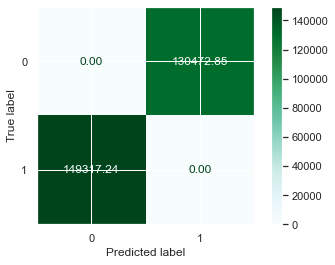

In [491]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

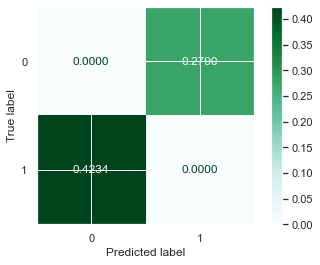

In [492]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, True)).plot(cmap = plt.cm.BuGn, values_format = ".4f")

The entry [1,2] describes how our model performs compared to a model which classifies all purchases as returns. The lower this value the lower are the missed profits from not discouraging the customer to place their order. Conversely, the entry [2,1] describes how our model performed compared to a model which flags every purchase as an item which will not be returned. The lower this values the less costs occur from handling the return. 

Finally, we can compare our model in this manner with a model that randomly flags whether an item is returned using the parameter *rnd*.

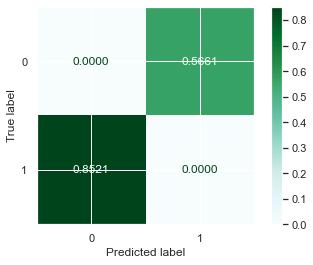

In [493]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, True, True)).plot(cmap = plt.cm.BuGn, values_format = ".4f")

Compare with an algorithm that just inteprets the target variable as Bernoulli distributed random variable, i.e. $y_i \thicksim \text{Bern}($p$)$. Our estimator is thus given by $\mathbb{P}(y_i = 1 | X_i) = \text{E}[\mathbb{1}_{\{y_i = 1\}}| X_i] = \text{E}[y_i] = p$. We display $p \in \{0.25, 0.01\}$ for comparison.

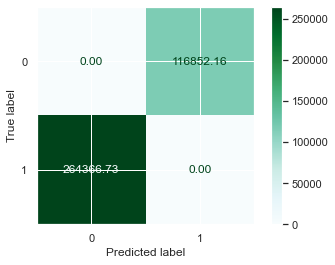

In [494]:
preds_bernoulli = stats.bernoulli.rvs(0.25, loc = 0, size = len(y_test))
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds_bernoulli, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

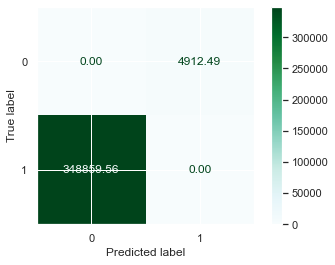

In [495]:
preds_bernoulli = stats.bernoulli.rvs(0.01, loc = 0, size = len(y_test))
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds_bernoulli, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

### Further analytics of predictions.

Create a new data frame with *item_price*, *pred_type* (TP, FN, ...), *y_true*, *y_pred* and the prediction probabilities *pred_proba*.

In [496]:
# Create variable pred_type
def predict_type(x, y):
    if((x == 1) and (y == 1)):
        return("TP")
    elif((x == 0) and (y == 1)):
        return("FP")
    elif((x == 0) and (y == 0)):
        return("TN")
    else:
        return("FN")

pred_type = []

for i in range(y_test.shape[0]):
    pred_type.append(predict_type(1 * y_test[y_test.index[i]], preds[i]))
    #print(y_test[i])
#pred_type = pd.Series(pred_type, index = y_test.index).astype("category")
test = {"item_price" : X_test.item_price.tolist(),
       "pred_type" : pred_type,
       "y_true" : y_test.tolist(),
       "y_pred" : list(preds.astype(bool)),
       "pred_proba" : list(randomized_auc.predict_proba(X_test)[:,1])}
data_post_proc = pd.DataFrame(test,
             index = y_test.index,
             columns = ["item_price", "pred_type", "y_true", "y_pred", "pred_proba"])
data_post_proc.pred_type = data_post_proc.pred_type.astype("category")
data_post_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29679 entries, 3548 to 70119
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   item_price  29679 non-null  float64 
 1   pred_type   29679 non-null  category
 2   y_true      29679 non-null  bool    
 3   y_pred      29679 non-null  bool    
 4   pred_proba  29679 non-null  float64 
dtypes: bool(2), category(1), float64(2)
memory usage: 2.0 MB


Display a violinplot for each prediction type with item price as the independent variable.

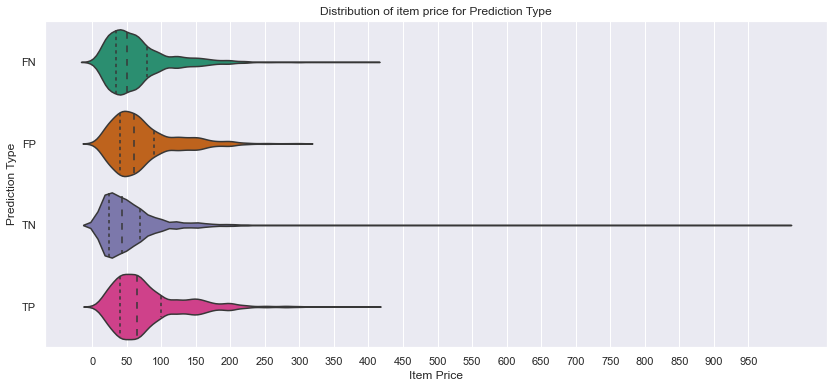

In [497]:
plt.figure(figsize= (14,6))
sns.set_theme(style = "darkgrid", palette = "Dark2")
sns.violinplot(y = "pred_type", x = "item_price",
                           split=True, inner="quart",
                           data= data_post_proc, scale = "width")
plt.title("Distribution of item price for Prediction Type")
plt.xlabel("Item Price")
plt.ylabel("Prediction Type")
plt.xticks(np.arange(min(data_post_proc.item_price), max(data_post_proc.item_price), 50))
plt.show()

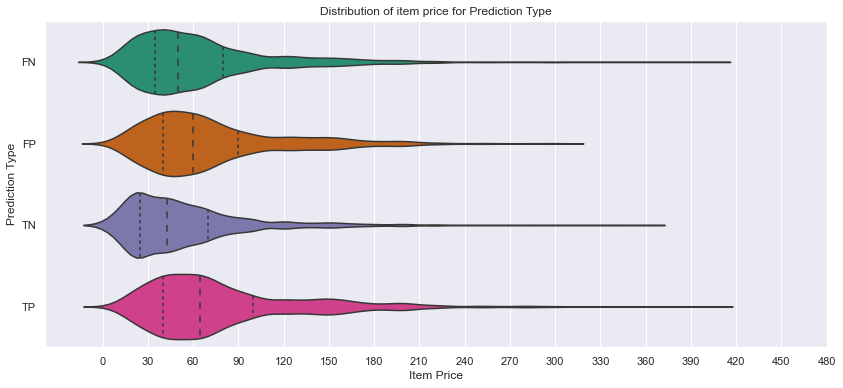

In [498]:
# Without outliers
plt.figure(figsize= (14,6))
sns.set_theme(style = "darkgrid", palette = "Dark2")
sns.violinplot(y = "pred_type", x = "item_price",
                           split=True, inner="quart",
                           data= data_post_proc[data_post_proc.item_price <= 500], scale = "width")
plt.title("Distribution of item price for Prediction Type")
plt.xlabel("Item Price")
plt.ylabel("Prediction Type")
plt.xticks(np.arange(min(data_post_proc.item_price), 500, 30))
plt.show()

Heatmap of correlation of prediction probability and item_price

<AxesSubplot:>

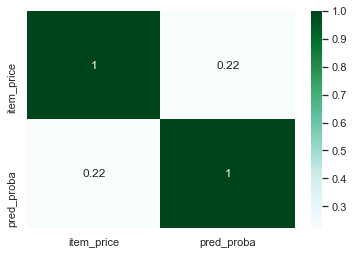

In [499]:
corr =  data_post_proc.loc[:, ["item_price", "pred_proba"]].corr()
#plt.figure(figsize= (8,6))
sns.heatmap(corr, annot = True, cmap="BuGn")

Create .csv of predictions for unknown data set

In [ ]:
data_u = pd.read_pickle('./data/unknown_cleaned_w_dummies')

In [10]:
preds = np.where(randomized_auc.predict_proba(X_test)[:, 1] >= cutoff_opt, 1, 0)
predict_unknown = pd.Series(preds, index=data_u["item_id"].index, name='return')
predict_unknown.to_csv("final_pred.csv")

NameError: name 'randomized_auc' is not defined

# 6. Conclusion